### Team with Kubra (muvis)

- Adding new dependencies?
- xrmreader https://pypi.org/project/xrmreader/
- https://dxchange.readthedocs.io/en/latest/source/api/dxchange.reader.html#dxchange.reader.read_xrm


- Testing Diondo Reader with https://zenodo.org/records/17167576

In [15]:

import numpy as np
import logging
import tifffile as tiff
import time
import os
import glob
import matplotlib.pyplot as plt
import multiprocessing
from cil.utilities.display import show2D, show_geometry


# import gc  # module for the cleaning the memory
# from tkinter import Tk, filedialog, simpledialog, messagebox
# from tkinter import Tk, Label, Button, IntVar, Radiobutton, Checkbutton, filedialog, simpledialog, messagebox,font

import xml.etree.ElementTree as ET
import threading


# first test it, create 2 options
from joblib import Parallel, delayed # parallel uploding 

from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.framework import ImageData, ImageGeometry
from cil.processors import Slicer, AbsorptionTransmissionConverter, TransmissionAbsorptionConverter,CentreOfRotationCorrector,Binner,Normaliser, Padder
from cil.utilities.display import show2D, show_geometry 
from cil.recon import FDK
from cil.plugins.tigre import FBP # check if FDK works with 2D

from cil.io import TIFFWriter, RAWFileWriter

In [3]:
class DiondoDataReader(object):
    
    """
    Optimized reader for Diondo XML metadata and projection data (RAW format)

    Modes:
    1 = Load 360 projections only (evenly spaced from the available all projections)
    2 = Load full dataset (all of projections)
    3 = Load only central slices from each of the all projections (2D slice)

    Binning:
    - Applied only for Mode 1 & Mode 2 (3D reconstructions)
    - User can enable binning via `apply_binning=True` and set `binning_step`
    """

    ### raise error when mode is not 1,2 or 3???
    ### fix documentation
    ### joblibe when reading raw files, give 2 options depending on external libs?
    ### why mode 3 takes so much time , should be quick

    def __init__(self, xml_file=None, projection_path=None, 
       show          dtype=np.uint16, normalise=False, 
                 fliplr=False, mode=1):
        self.xml_file        = xml_file
        self.projection_path = projection_path
        self.dtype           = dtype
        self.normalise       = normalise
        # self.fliplr          = fliplr
        self.geometry        = None
        self.shape           = None
        self.mode            = mode
        self.imaging_type    = None        
        if xml_file is not None:
            self.set_up()

    def _read_single_raw_file(self, raw_file, height, width, dtype):
        with open(raw_file, "rb") as f:
            return np.fromfile(f, dtype=dtype).reshape((height, width))            

    def set_up(self):
        """Parses the XML file and extracts relevant geometry information."""
        if not os.path.isfile(self.xml_file):
            raise FileNotFoundError("XML file not found.")

        tree = ET.parse(self.xml_file)
        root = tree.getroot()

        geom = root.find("Geometrie")
        recon = root.find("Recon")

        self.source_to_detector = float(geom.find("SourceDetectorDist").text)
        self.source_to_object   = float(geom.find("SourceObjectDist").text)
        self.object_to_detector = float(geom.find("ObjectDetectorDist").text)

        self.pixel_size_h       = float(recon.find("ProjectionPixelSizeX").text)
        self.pixel_size_v       = float(recon.find("ProjectionPixelSizeY").text)

        self.num_projections    = int(recon.find("ProjectionCount").text)
        self.num_pixels_h       = int(recon.find("ProjectionDimX").text)
        self.num_pixels_v       = int(recon.find("ProjectionDimY").text)

        # Load all available RAW files
        raw_files = sorted(glob.glob(os.path.join(self.projection_path, "*.raw")))
        
        if len(raw_files) == 0:
            raise FileNotFoundError("No RAW files found in the projection path.")

        #### This is important mention inside __init__ and documentation
        # Example: Always exclude the last file (1251 → 1250)
        if len(raw_files) > 1:
            raw_files = raw_files[:-1]

        self.total_available_projections = len(raw_files)  

        # **Mode 1: Select 360 evenly spaced projections**
        if self.mode == 1:
            self.num_projections_to_load = min(360, self.total_available_projections)

            # check if we need the -1, since we do not consider the last one above
            selected_indices = np.linspace(0, self.total_available_projections - 1, self.num_projections_to_load, dtype=int)
            self.raw_files = [raw_files[i] for i in selected_indices]
            print(f" Mode 1: Loading {self.num_projections_to_load} evenly spaced projections from {self.total_available_projections}.")

        # **Mode 2: Load all projections**
        elif self.mode == 2:
            self.num_projections_to_load = self.total_available_projections
            self.raw_files = raw_files
            print(f" Mode 2: Loading all {self.num_projections_to_load} projections.")

        # **Mode 3: Load only the central slices**
        elif self.mode == 3:
            self.num_projections_to_load = self.total_available_projections
            self.raw_files = raw_files
            print(f" Mode 3: Loading central slices from all {self.num_projections_to_load} projections.")

        self.shape = (self.num_projections_to_load, self.num_pixels_v, self.num_pixels_h)

        # Set up geometry
        self._setup_geometry()

    def _setup_geometry(self):
        """Creates the AcquisitionGeometry object based on parsed data."""
        if self.mode == 3:
            print("Mode 3: Using 2D Cone Beam Geometry.")
            self.imaging_type = "2D Cone Beam - FBP Recon"  # Set the geometry type correctly
            self.geometry = AcquisitionGeometry.create_Cone2D(
                source_position=[0, -self.source_to_object],
                detector_position=[0, self.source_to_detector - self.source_to_object]
            )
            self.geometry.set_panel(self.num_pixels_h, pixel_size=self.pixel_size_h, origin='top-left')
            self.geometry.set_labels(['angle', 'horizontal'])
        else:
            print("Mode 1 or 2: Using 3D Cone Beam Geometry.")
            self.imaging_type = "3D Cone Beam - FDK Recon"  # Set the geometry type correctly
            self.geometry = AcquisitionGeometry.create_Cone3D(
                source_position=[0, -self.source_to_object, 0],
                detector_position=[0, self.source_to_detector - self.source_to_object, 0]
            )
            self.geometry.set_panel((self.num_pixels_h, self.num_pixels_v),
                                    pixel_size=(self.pixel_size_h, self.pixel_size_v), origin='top-left')
            self.geometry.set_labels(['angle', 'vertical', 'horizontal'])

        # check the offset above
        # or add initial_angle in .set_angles
        if self.mode == 1:            
            self.angles = np.linspace(-90, 270, self.num_projections_to_load, endpoint=False)
        else:
            self.angles = np.linspace(-90, 270, self.total_available_projections, endpoint=False)
        self.geometry.set_angles(self.angles, angle_unit='degree')

    def get_geometry(self):
        """Returns the AcquisitionGeometry object."""
        return self.geometry
        
    def get_imaging_type(self):
        """Returns the type of geometry (2D or 3D Cone beam)."""
        return self.imaging_type

    def get_mode_description(self):

        """Returns a detailed description of the selected mode."""
        if self.mode == 1:
            return f"Mode 1: 360 evenly spaced projections (out of {self.total_available_projections})"

        elif self.mode == 2:
            return f"Mode 2: Full dataset with {self.total_available_projections} projections"

        elif self.mode == 3:
            return f"Mode 3: Central slice mode (2D) from all {self.total_available_projections} projections"

        else:
            return f"Unknown mode: {self.mode}"

    def read_raw_projections(self):
        """Reads RAW projection data based on mode, applies padding & binning if needed."""
        if self.projection_path is None:
            raise ValueError("Projection data path is not set.")
        if self.shape is None:
            raise ValueError("Could not determine projection shape from XML.")

        if self.mode == 3:
            data = self._read_central_slices()
        else:
            data = self._read_full_projections()

        return data
        

    def _read_full_projections(self):
        """Loads full projection data for Mode 1 and 2."""
        num_projections, height, width = self.shape
                
        n_threads = max(1, multiprocessing.cpu_count() // 2)

        projection_data = Parallel(n_jobs=n_threads, backend='threading')(
        delayed(self._read_single_raw_file)(raw_file, height, width, self.dtype)
        for raw_file in self.raw_files )
                       
        projection_data = np.stack(projection_data, axis=0)

        return AcquisitionData(array=projection_data, geometry=self.geometry)

    def _read_central_slices(self):
        """Reads only the central slice from each RAW projection (Mode 3)."""
        central_index = self.shape[1] // 2  

        central_slices = np.zeros((self.num_projections_to_load, self.shape[2]), dtype=self.dtype)

        for i, raw_file in enumerate(self.raw_files):
            with open(raw_file, "rb") as f:
                f.seek(central_index * self.shape[2] * np.dtype(self.dtype).itemsize)
                central_slices[i] = np.fromfile(f, dtype=self.dtype, count=self.shape[2])

        return AcquisitionData(array=central_slices, geometry=self.geometry)

In [4]:
path    = r'20240508_d5_3917_AV_trustfireAAA_overv'
xml_file_name    = r'20240508_d5_3917_AV_trustfireAAA_overv.xml'
proj_file_name = r'20240508_d5_3917_AV_trustfireAAA_overv'


### mode = 1

In [13]:
t1 = time.time()
data_reader = DiondoDataReader(xml_file=xml_file_name, 
                               projection_path=proj_file_name, 
                               mode=1)
data = data_reader.read_raw_projections()
print(f" It took {time.time() - t1} sec for mode 1")

 Mode 1: Loading 360 evenly spaced projections from 1250.
Mode 1 or 2: Using 3D Cone Beam Geometry.
 It took 18.693859338760376 sec for mode 1


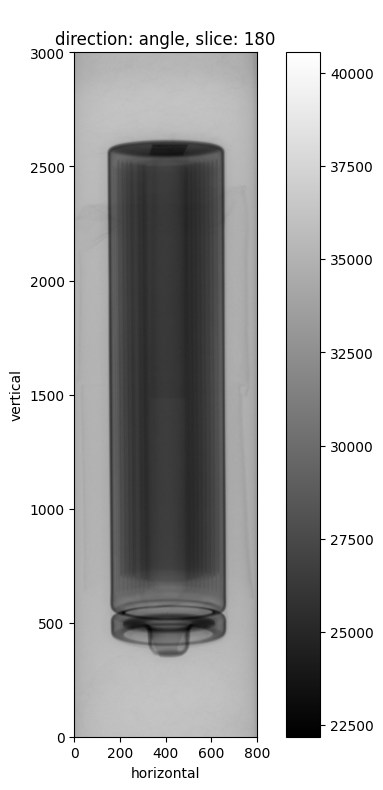

In [14]:
show2D(data)

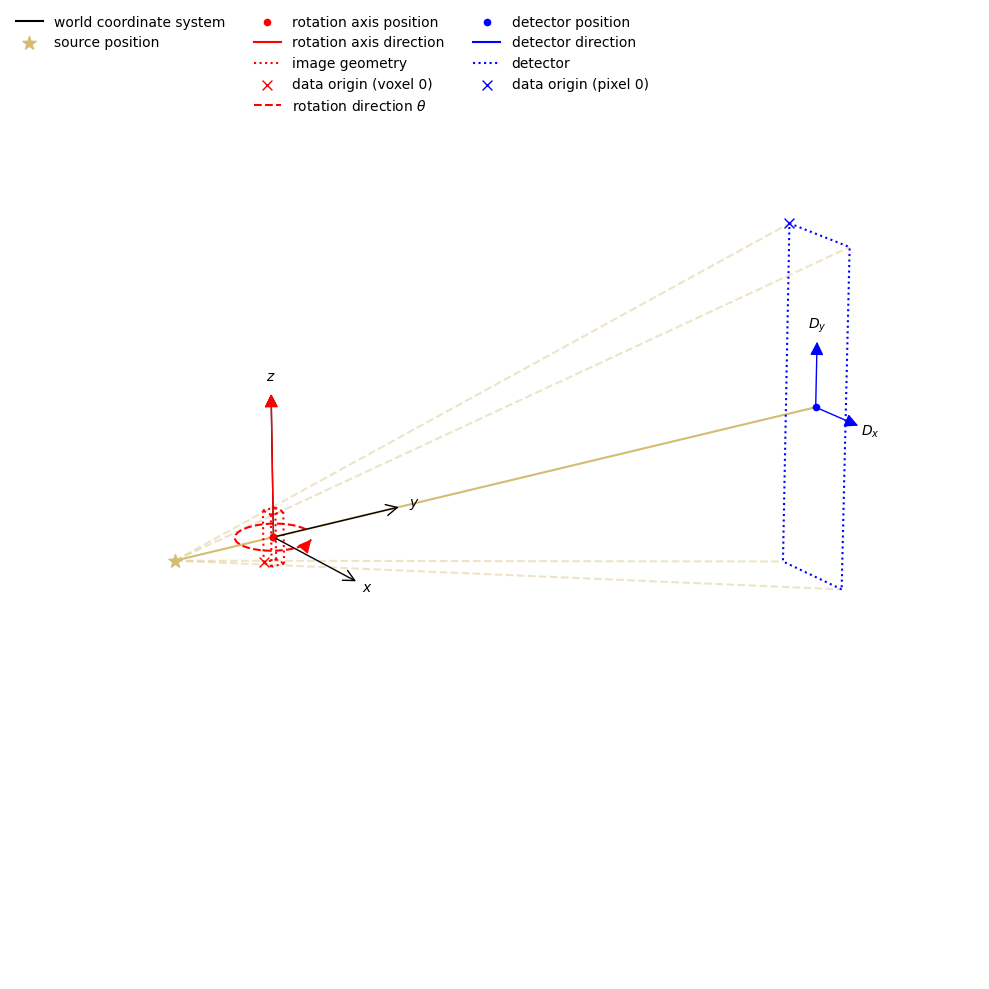

In [17]:
show_geometry(data.geometry)

### mode = 2  

In [9]:
t1 = time.time()
data_reader = DiondoDataReader(xml_file=xml_file_name, 
                               projection_path=proj_file_name, 
                               mode=2)
data = data_reader.read_raw_projections()
print(f" It took {time.time() - t1} sec for mode 2")

 Mode 2: Loading all 1250 projections.
Mode 1 or 2: Using 3D Cone Beam Geometry.
 It took 63.233951807022095 sec for mode 2


### mode = 3

In [10]:
t1 = time.time()
data_reader = DiondoDataReader(xml_file=xml_file_name, 
                               projection_path=proj_file_name, 
                               mode=3)
data = data_reader.read_raw_projections()
print(f" It took {time.time() - t1} sec for mode 3")

 Mode 3: Loading central slices from all 1250 projections.
Mode 3: Using 2D Cone Beam Geometry.
 It took 33.768070697784424 sec for mode 3


In [ ]:
### 

 Mode 3: Loading central slices from all 1250 projections.
Mode 3: Using 2D Cone Beam Geometry.


In [23]:
data.shape

(1250, 800)

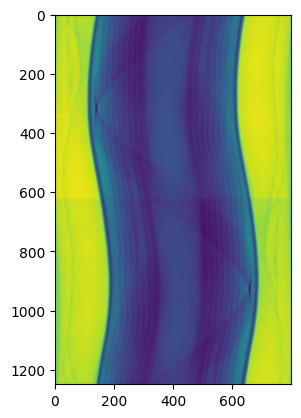